In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('../data/samu_cases_raw.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57040 entries, 0 to 57039
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   data                57040 non-null  object 
 1   hora_minuto         57040 non-null  object 
 2   municipio           57040 non-null  object 
 3   bairro              57040 non-null  object 
 4   endereco            54818 non-null  object 
 5   origem_chamado      57040 non-null  object 
 6   tipo                57040 non-null  object 
 7   subtipo             57035 non-null  object 
 8   sexo                55995 non-null  object 
 9   idade               51597 non-null  float64
 10  motivo_finalizacao  15760 non-null  object 
 11  motivo_desfecho     57040 non-null  object 
dtypes: float64(1), object(11)
memory usage: 5.2+ MB


### Translating columns

In [31]:
columns_translate = {
    'data': 'date',
    'hora_minuto': 'timestamp',
    'municipio': 'city',
    'bairro': 'neighborhood',
    'endereco': 'address',
    'origem_chamado': 'call_origin',
    'tipo': 'type',
    'subtipo': 'subtype',
    'sexo': 'gender',
    'idade': 'age',
    'motivo_finalizacao': 'finalization_reason',
    'motivo_desfecho': 'outcome'
}

df = df.rename(columns=columns_translate)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57040 entries, 0 to 57039
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 57040 non-null  object 
 1   timestamp            57040 non-null  object 
 2   city                 57040 non-null  object 
 3   neighborhood         57040 non-null  object 
 4   address              54818 non-null  object 
 5   call_origin          57040 non-null  object 
 6   type                 57040 non-null  object 
 7   subtype              57035 non-null  object 
 8   gender               55995 non-null  object 
 9   age                  51597 non-null  float64
 10  finalization_reason  15760 non-null  object 
 11  outcome              57040 non-null  object 
dtypes: float64(1), object(11)
memory usage: 5.2+ MB


#### Removing duplicity calls 

In [32]:
df['finalization_reason'].unique()
df = df[df['finalization_reason'] != 'SOLICITAÇÃO DUPLICADA']

#### Filtering Death and Succefull cases

In [33]:
df_cases = df[
    (df['outcome'].str.contains('ÓBITO')) |
    (df['outcome'].str.contains('ÊXITO')) 
]

df_cases['outcome'].value_counts()

outcome
1. OCORRÊNCIA CONCLUÍDA COM ÊXITO    23539
13. ÓBITO ANTES DO ATENDIMENTO        1083
14. ÓBITO DURANTE O ATENDIMENTO        128
Name: count, dtype: int64

#### Handle outliers

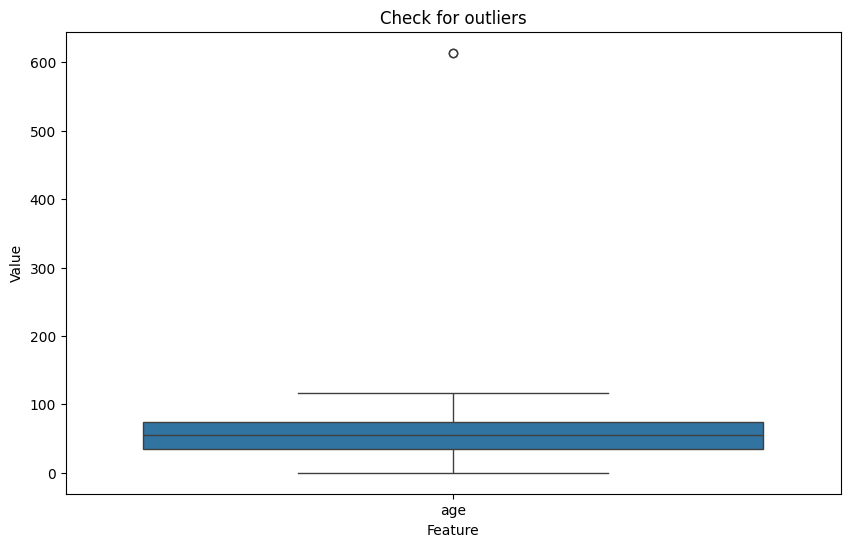

In [34]:
import seaborn as sns

numerical_columns = df_cases.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 6))
sns.boxplot(data=numerical_columns)
plt.title('Check for outliers')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()



In [35]:
## convert string ages to numeric 
df_cases.loc[:, 'age'] = pd.to_numeric(df_cases['age'], errors='coerce')

# check for outliers
df_cases['age'].sort_values(ascending=False).head()

43172    614.0
49297    614.0
24632    117.0
21420    116.0
30491    107.0
Name: age, dtype: float64

In [36]:
# Change outliers to NaN
df_cases.loc[df_cases['age'] > 120, 'age'] = np.nan
df_cases['age'].sort_values(ascending=False).head()

24632    117.0
21420    116.0
30491    107.0
36799    107.0
5047     106.0
Name: age, dtype: float64

#### Handle missing values

In [37]:
df_cases.isnull().sum()

date                       0
timestamp                  0
city                       0
neighborhood               0
address                 1394
call_origin                0
type                       0
subtype                    0
gender                   415
age                     1454
finalization_reason    24747
outcome                    0
dtype: int64

##### Predict missing ages:

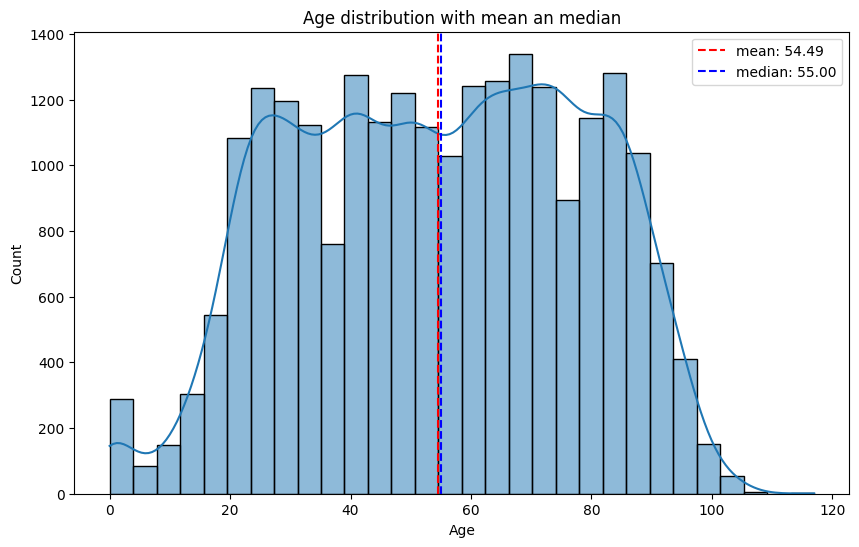

In [38]:

# ploting the median and mean to compare with KNN imputer
mean_age = df_cases['age'].mean()
median_age = df_cases['age'].median()

plt.close('all')
plt.figure(figsize=(10,6))
sns.histplot(df_cases['age'].dropna(), kde=True, bins=30)
plt.axvline(mean_age, color='red', linestyle='--', label=f'mean: {mean_age:.2f}')
plt.axvline(median_age, color='blue', linestyle='--', label=f'median: {median_age:.2f}')
plt.title('Age distribution with mean an median')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()


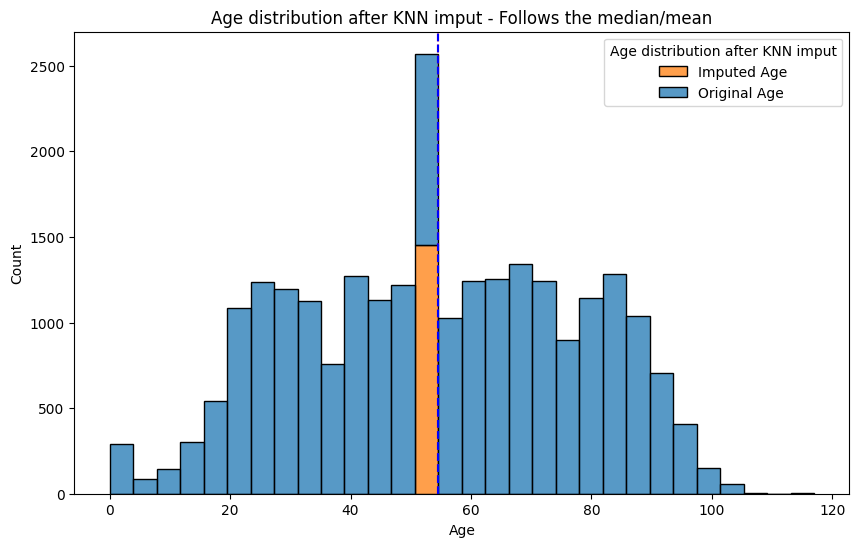

In [39]:
from sklearn.impute import KNNImputer

# KNN imputer to predict missing ages
imputer = KNNImputer(n_neighbors=5)
df_with_age_prediction = df_cases.copy()
df_with_age_prediction.loc[:, 'knn_age'] = imputer.fit_transform(df_cases[['age']])
df_with_age_prediction.loc[:, 'imputed_age_flag'] = df_cases['age'].isna().astype(int)

mean_age = df_with_age_prediction['knn_age'].mean()
median_age = df_with_age_prediction['knn_age'].median()

plt.figure(figsize=(10,6))
sns.histplot(df_with_age_prediction, hue='imputed_age_flag', x='knn_age', bins=30, label='Original', multiple='stack')
plt.title('Age distribution after KNN imput - Follows the median/mean')
plt.legend(title='Age distribution after KNN imput', labels=['Imputed Age', 'Original Age'])
plt.axvline(mean_age, color='red', linestyle='--', label=f'mean: {mean_age:.2f}')
plt.axvline(median_age, color='blue', linestyle='--', label=f'median: {median_age:.2f}')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


#### Discretize ages:

In [40]:
df_with_age_prediction.loc[:, 'age'] = df_with_age_prediction['knn_age']

/var/folders/4v/h4yyclp95bs61r9ynsn9gkfm0000gn/T/ipykernel_12790/2641702268.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


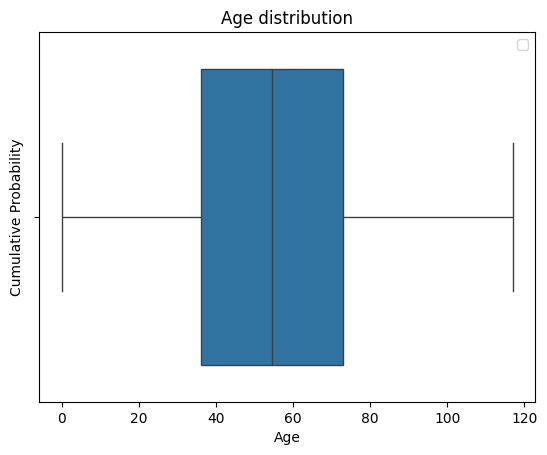

Q1: 36.0
Q2: 54.48677884615385
Q3: 73.0


In [41]:
ax = sns.boxplot(x=df_with_age_prediction['age'])

age_q1 = df_with_age_prediction['age'].quantile(0.25)
age_q2 = df_with_age_prediction['age'].quantile(0.5)
age_q3 = df_with_age_prediction['age'].quantile(0.75)

plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

print(f'Q1: {age_q1}')
print(f'Q2: {age_q2}')
print(f'Q3: {age_q3}')


In [42]:
def discretize_age(age):
    """
    it discretizes the age based on 4Q
    """
    if age <= age_q1:
      return 0 # <= 33
    elif age_q1 < age <= age_q2:
      return 1 # 34 - 52
    elif age_q2 < age <= age_q3:
      return 2 # 53 - 70
    else:
      return 3 # >= 71

df_with_discretized_ages = df_with_age_prediction.copy()
df_with_discretized_ages['age'] = df_with_discretized_ages.loc[:,'age'].apply(discretize_age).astype('category')
df_with_discretized_ages['age'].value_counts()

age
1    6716
0    6243
3    6043
2    5748
Name: count, dtype: int64

#### Fixing gender values

In [43]:
df_boolean_gender = df_with_discretized_ages.copy()
df_boolean_gender['gender'].unique()

array(['FEMININO', 'MASCULINO', nan], dtype=object)

In [44]:
## Converting male to 0 and female to 1
df_boolean_gender['gender'] = df_boolean_gender['gender'].map({'FEMININO': 1, 'MASCULINO': 0})
df_boolean_gender['gender'].unique()


array([ 1.,  0., nan])

In [45]:
# Imputing gender with KNN
imputer = KNNImputer(n_neighbors=5)
df_imputed_genders = df_boolean_gender.copy()
df_imputed_genders.loc[:, 'knn_gender'] = imputer.fit_transform(df_imputed_genders[['gender']])

# # round imputed results to 0 or 1
df_imputed_genders.loc[:, 'knn_gender'] = np.round(df_imputed_genders['knn_gender']).astype(int)
df_imputed_genders['gender'] = df_imputed_genders['knn_gender']
df_imputed_genders['gender'].unique()


array([1., 0.])

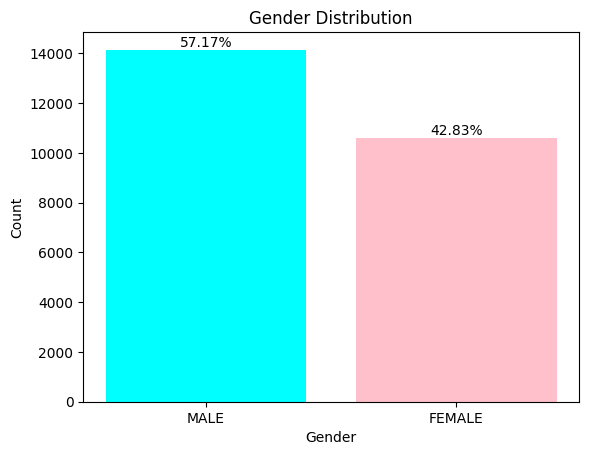

In [46]:
gender_counts = df_imputed_genders['gender'].value_counts()
total_gender_counts = gender_counts.sum()
gender_percentages = (gender_counts / total_gender_counts) * 100


bars = plt.bar(['MALE', 'FEMALE'], gender_counts, color=['cyan', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

for bar, percentage in zip(bars, gender_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

In [47]:
df_imputed_genders.isnull().sum()

date                       0
timestamp                  0
city                       0
neighborhood               0
address                 1394
call_origin                0
type                       0
subtype                    0
gender                     0
age                        0
finalization_reason    24747
outcome                    0
knn_age                    0
imputed_age_flag           0
knn_gender                 0
dtype: int64

In [48]:
# drop non-needed columns finalization_reason and address
df_imputed_genders.dropna(inplace=True, axis=1)
df_imputed_genders.isnull().sum()

date                0
timestamp           0
city                0
neighborhood        0
call_origin         0
type                0
subtype             0
gender              0
age                 0
outcome             0
knn_age             0
imputed_age_flag    0
knn_gender          0
dtype: int64

#### Discretize timestamp
As we have ruge range of timestamps from calls during the day, let **discretize** the timestamps:
 - From 00:00 to 05:59 - early (6 hours)
 - From 06:00 to 11:59 - morning (6 hours)
 - From 12:00 to 17:59 - afternoon (6 hours)
 - From 18:00 to 23:59 - nigth (6 hours)

In [49]:

def discretize_time(time):
  if 0 <= time.hour < 6:
      return 'early'
  elif 6 <= time.hour < 12:
      return 'morning'
  elif 12 <= time.hour < 18:
      return 'afternoon'
  else:
      return 'night'


df_discretized_timestamp = df_imputed_genders.copy()
df_discretized_timestamp['timestamp'] = pd.to_datetime(df_discretized_timestamp['timestamp']).dt.time
df_discretized_timestamp['timestamp'] = df_discretized_timestamp['timestamp'].apply(discretize_time).astype('category')
df_discretized_timestamp['timestamp'].value_counts()

/var/folders/4v/h4yyclp95bs61r9ynsn9gkfm0000gn/T/ipykernel_12790/4013766012.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_discretized_timestamp['timestamp'] = pd.to_datetime(df_discretized_timestamp['timestamp']).dt.time


timestamp
morning      8443
afternoon    8091
night        5386
early        2830
Name: count, dtype: int64

In [50]:
df_discretized_timestamp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24750 entries, 0 to 57038
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   date              24750 non-null  object  
 1   timestamp         24750 non-null  category
 2   city              24750 non-null  object  
 3   neighborhood      24750 non-null  object  
 4   call_origin       24750 non-null  object  
 5   type              24750 non-null  object  
 6   subtype           24750 non-null  object  
 7   gender            24750 non-null  float64 
 8   age               24750 non-null  category
 9   outcome           24750 non-null  object  
 10  knn_age           24750 non-null  float64 
 11  imputed_age_flag  24750 non-null  int64   
 12  knn_gender        24750 non-null  float64 
dtypes: category(2), float64(3), int64(1), object(7)
memory usage: 2.3+ MB


#### Select features and target

In [57]:
df_required_columns = df_discretized_timestamp[['timestamp', 'type', 'subtype', 'gender', 'age', 'outcome']]
df_required_columns.head()


,timestamp,type,subtype,gender,age,outcome
0,afternoon,CARDIOLOGICA,PARADA CARDIACA,1.0,1,13. ÓBITO ANTES DO ATENDIMENTO
1,morning,RESPIRATORIA,DISPNEIA,0.0,2,13. ÓBITO ANTES DO ATENDIMENTO
2,morning,NEUROLOGICA,REBAIXAMENTO DA CONSCIENCIA,1.0,2,14. ÓBITO DURANTE O ATENDIMENTO
3,morning,CARDIOLOGICA,PARADA CARDIACA,1.0,0,14. ÓBITO DURANTE O ATENDIMENTO
4,morning,CARDIOLOGICA,PARADA CARDIACA,1.0,2,13. ÓBITO ANTES DO ATENDIMENTO


In [58]:
## deaths to 1 and success to 0
df_ready = df_required_columns.copy()
df_ready.loc[:, 'outcome'] = df_required_columns['outcome'].str.contains('ÓBITO').astype(int)
df_ready['outcome'].value_counts(normalize=True)

outcome
0    0.951071
1    0.048929
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Total number of successful cases and deaths before or during the medical care (24750)')

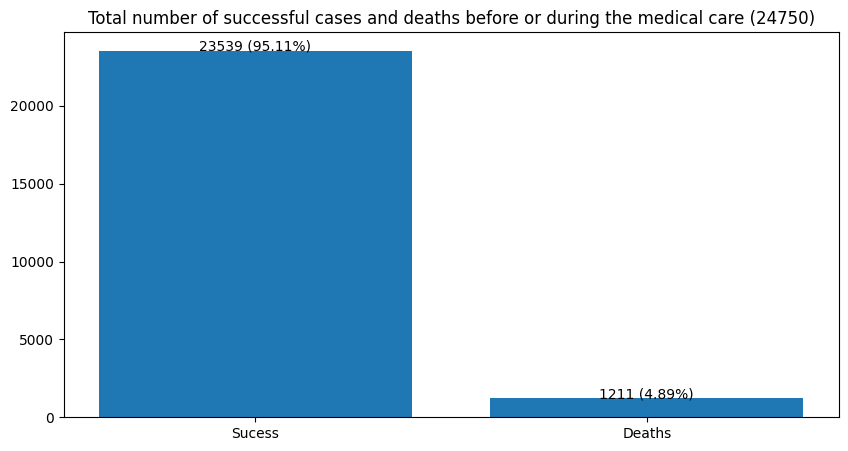

In [59]:

death_cases = df_ready[df_ready['outcome'] == 1]
success_cases = df_ready[df_ready['outcome'] == 0]

death_cases_count = death_cases['outcome'].count()
success_cases_count = success_cases['outcome'].count()

total_cases = death_cases_count + success_cases_count   

# how to add the percentage to the labels
plt.figure(figsize=(10, 5))
plt.bar(['Sucess', 'Deaths' ], [success_cases_count, death_cases_count])
plt.text(1, death_cases_count, f'{death_cases_count} ({death_cases_count/total_cases:.2%})', ha='center')
plt.text(0, success_cases_count, f'{success_cases_count} ({success_cases_count/total_cases:.2%})', ha='center')
plt.title(f'Total number of successful cases and deaths before or during the medical care ({total_cases})')

### For imbalanced data with a large dataset (25000 rows), we gonna use the Undersampling Strategy

In [60]:
df_ready.to_csv('../data/samu_cases_ready.csv', index=False)

In [63]:
df_ready['subtype'].unique().tolist()

['PARADA CARDIACA',
 'DISPNEIA',
 'REBAIXAMENTO DA CONSCIENCIA',
 'TENTATIVA DE SUICIDIO',
 'HIPOGLICEMIA',
 'QUEDA DA PROPRIA ALTURA',
 'CONVULSAO',
 'OUTROS',
 'DESMAIO',
 'ACIDENTE DE TRANSITO ENVOLVENDO MOTO',
 'INSUFICIENCIA RESPIRATORIA AGUDA',
 'ACIDENTE DE TRANSITO COM CARROS',
 'QUEDA DE NIVEL',
 'ANGINA',
 'DESNUTRICAO',
 'AGRESSAO POR ARMA BRANCA',
 'AGRESSAO POR ARMA DE FOGO',
 'NEOPLASIA PULMONAR/DE VIAS AEREAS',
 'DISPNEIA DE CAUSA CARDIACA',
 'AVC / AVE',
 'VOMITOS',
 'NEOPLASIA ABDOMINAL',
 'DOR PRECORDIAL',
 'ACIDENTE DE TRANSITO ENVOLVENDO BICICLETA',
 'ATROPELAMENTO POR ONIBUS OU CAMINHAO',
 'ARRITMIA CARDIACA',
 'HIPOTERMIA',
 'DIABETES',
 'INFARTO AGUDO DO MIOCARDIO',
 'AGRESSAO FISICA',
 'INTOXICACAO EXOGENA',
 'INSUFICIENCIA RENAL',
 'AFOGAMENTO/SUBMERSAO',
 'HIPERGLICEMIA',
 'ATROPELAMENTO POR CARRO',
 'CHOQUE ELETRICO',
 'CASO SUSPEITO COVID-19',
 'CONFUSAO MENTAL',
 'HEMORRAGIA DIGESTIVA ALTA',
 'INFECCAO RESPIRATORIA',
 'ABDOME AGUDO',
 'DOR ABDOMINAL',
 'DOR